### **Investigação — Random forest básico** 

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.inspection import permutation_importance

#### **Pré-processamento dos dados**
***

* **Colunas removidas:**
    * <div style="display: flex; align-items: center; width: 75%;"><span>cod</span><div style="flex: 1; border-bottom: 1px dotted; margin: 0 10px;"></div><span>Número consecutivo asignado por el investigador</span></div>
    * <div style="display: flex; align-items: center; width: 75%;"><span>fechaingreso</span><div style="flex: 1; border-bottom: 1px dotted; margin: 0 10px;"></div><span>Fecha de ingreso del paciente al centro de excelencia o proyecto de investigación</span></div>
    * <div style="display: flex; align-items: center; width: 75%;"><span>anioingreso</span><div style="flex: 1; border-bottom: 1px dotted; margin: 0 10px;"></div><span>Año de ingreso del paciente al centro de excelencia o proyecto de investigación</span></div>
    * <div style="display: flex; align-items: center; width: 75%;"><span>Fecha aplicación (Fecha aplicación1)</span><div style="flex: 1; border-bottom: 1px dotted; margin: 0 10px;"></div><span>Fecha de aplicación primera dosis vacuna para COVID-19</span></div>
    * <div style="display: flex; align-items: center; width: 75%;"><span>Fecha aplicación.1 (Fecha aplicación2)</span><div style="flex: 1; border-bottom: 1px dotted; margin: 0 10px;"></div><span>Fecha de aplicación segunda dosis de vacuna para COVID-19</span></div>
    * <div style="display: flex; align-items: center; width: 75%;"><span>Fecha aplicación.2 (Fecha aplicación3)</span><div style="flex: 1; border-bottom: 1px dotted; margin: 0 10px;"></div><span>Fecha de aplicación tercera dosis vacuna para COVID-19</span></div>
    * <div style="display: flex; align-items: center; width: 75%;"><span>Fecha aplicación.3 (Fecha aplicación4)</span><div style="flex: 1; border-bottom: 1px dotted; margin: 0 10px;"></div><span>Fecha de aplicación cuarta dosis vacuna para COVID-19</span></div>
    * <div style="display: flex; align-items: center; width: 75%;"><span>Fecha mortalidad</span><div style="flex: 1; border-bottom: 1px dotted; margin: 0 10px;"></div><span>Fecha del fallecimiento del paciente</span></div>
    * <div style="display: flex; align-items: center; width: 75%;"><span>Fecha trasplante</span><div style="flex: 1; border-bottom: 1px dotted; margin: 0 10px;"></div><span>Fecha del trasplante</span></div>
    * <div style="display: flex; align-items: center; width: 75%;"><span>Fecha asistencia</span><div style="flex: 1; border-bottom: 1px dotted; margin: 0 10px;"></div><span>Fecha de la asistencia ventricular</span></div>
    * <div style="display: flex; align-items: center; width: 75%;"><span>Mortalidad tiempo</span><div style="flex: 1; border-bottom: 1px dotted; margin: 0 10px;"></div><span>Tiempo desde la fecha de ingreso a la fecha de muerte</span></div>
    * <div style="display: flex; align-items: center; width: 75%;"><span>IMC</span><div style="flex: 1; border-bottom: 1px dotted; margin: 0 10px;"></div><span>Índice de masa corporal calculado como peso (kg) / talla² (m²)</span></div>
    > *IMC removido pela existência de IMCat*


In [2]:
#Abrir dataset
df = pd.read_excel("Base_tesis_chagas_IA_250725(1).xlsx")
df = df.iloc[:-1, :]

#printar todas as variaveis para pre-processamento
resumo = pd.DataFrame({
    'tipo': df.dtypes,
    'nulos': df.isnull().sum()
})
pd.set_option('display.max_rows', None)     

#tirar colunas com fechas
df = df.drop(columns=["cod","IMC","fechaingreso", "anioingreso","Fecha aplicación","Fecha aplicación.1", "Fecha aplicación.2", "Fecha aplicación.3", "Fecha mortalidad", "Fecha trasplante", "Fecha asistencia", "Mortalidad tiempo", "Vacunación COVID", "Tipo vacuna", "Tipo vacuna.1","Tipo vacuna.2","Tipo vacuna.3", "Primera dosis", "segunda dosis", "Tercera dosis", "Cuarta dosis"])
#print(df.columns)

#mudar tipo objeto para numero
df["IMCat"] = df["IMCat"].astype("category")
print(df.dtypes["IMCat"]) 
print(df["IMCat"].cat.categories)
df["IMCat"] = df["IMCat"].cat.codes

print(df.head())

#PERGUNTAR: Precisa mesmo ter o tipo de vacina? ou a gente inclui mesmo e se não for importante descarta
print(len(df.columns))

a = pd.DataFrame({
    'tipo': df.dtypes,
    'nulos': df.isnull().sum()
})

print(a)

category
Index(['Bajo peso', 'Normal', 'Obesidad', 'Sobrepeso'], dtype='object')
   tipodepaciente  edad  sexo  estadocivil  arearesidencia  regimensalud  \
0             1.0  51.0   1.0          1.0             1.0           0.0   
1             1.0  43.0   0.0          1.0             1.0           0.0   
2             1.0  79.0   0.0          0.0             0.0           0.0   
3             1.0  62.0   1.0          1.0             1.0           1.0   
4             1.0  73.0   0.0          1.0             1.0           0.0   

   educacion  Fuma actualmente  Años de fumador  \
0        1.0               0.0              NaN   
1        1.0               0.0              NaN   
2        0.0               0.0              NaN   
3        0.0               0.0              NaN   
4        0.0               0.0              NaN   

   número de cigarrillos diarios  ...  Complicaciones cardiovasculares  \
0                            NaN  ...                              0.0   
1      

* **Colunas codificadas para números categóricos:**
    * <div style="display: flex; align-items: center; width: 75%;"><span>fevi</span><div style="flex: 1; border-bottom: 1px dotted; margin: 0 10px;"></div><span><strong>0</strong> (x ≤ 40); <strong>1</strong> (40 < x < 50); <strong>2</strong> (x ≥ 50)</span></div>
    * <div style="display: flex; align-items: center; width: 75%;"><span>NT proBNP</span><div style="flex: 1; border-bottom: 1px dotted; margin: 0 10px;"></div><span><strong>0</strong> (x < 450 [idade < 50], x < 900 [50 ≤ idade ≤ 75], x < 1800 [idade > 75]); <strong>1</strong> (Caso contrário)</span></div>
    * <div style="display: flex; align-items: center; width: 75%;"><span>edad</span><div style="flex: 1; border-bottom: 1px dotted; margin: 0 10px;"></div><span><strong>0</strong> (x < 75); <strong>1</strong> (x ≥ 75)</span></div>
    * <div style="display: flex; align-items: center; width: 75%;"><span>FC</span><div style="flex: 1; border-bottom: 1px dotted; margin: 0 10px;"></div><span><strong>0</strong> (x ≥ 100); <strong>1</strong> (60 ≤ x < 100); <strong>2</strong> (x < 60)</span></div>
    * <div style="display: flex; align-items: center; width: 75%;"><span>creatinina</span><div style="flex: 1; border-bottom: 1px dotted; margin: 0 10px;"></div><span><strong>0</strong> (x ≤ 1.1 [M], x ≤ 1.3 [H]); <strong>1</strong> (Caso contrário)</span></div>
    * <div style="display: flex; align-items: center; width: 75%;"><span>BUN</span><div style="flex: 1; border-bottom: 1px dotted; margin: 0 10px;"></div><span><strong>0</strong> (x ≤ 20); <strong>1</strong> (x > 20)</span></div>
    * <div style="display: flex; align-items: center; width: 75%;"><span>TAPSE</span><div style="flex: 1; border-bottom: 1px dotted; margin: 0 10px;"></div><span><strong>0</strong> (x ≥ 17); <strong>1</strong> (x < 17)</span></div>
    

In [3]:
#[fevi]-------------------------------------------------------------------------------

bins = [-float("inf"), 40, 50, float("inf")]
labels = [0, 1, 2]  # 0 = muito mal, 1 = mal, 2 = normal

df["fevi_cat"] = pd.cut(df["fevi"], bins=bins, labels=labels, right=False)

df = df.drop(columns="fevi")
# conferir
print(df["fevi_cat"].value_counts(dropna=False))

#[NT proBNP]--------------------------------------------------------------------------

def classificar_nt(row):
    idade = row["edad"] 
    nt = row["NT proBNP"]
    
    if pd.isnull(idade) or pd.isnull(nt):
        return np.nan
    
    if idade < 50:
        return 0 if nt < 450 else 1
    elif idade <= 75:
        return 0 if nt < 900 else 1
    else:
        return 0 if nt < 1800 else 1

df["NT proBNP_cat"] = df.apply(classificar_nt, axis=1)
df = df.drop(columns="NT proBNP")

print(df["NT proBNP_cat"].value_counts(dropna=False))

#[edad]-------------------------------------------------------------------------------

df["edad_cat"] = np.where(df["edad"] < 75, 0, 1)

print(df["edad_cat"].value_counts(dropna=False))
df = df.drop(columns="edad")

#[FC]---------------------------------------------------------------------------------

def classificar_fc(valor):
    if pd.isnull(valor):
        return np.nan
    elif valor >= 100:
        return 0
    elif valor >= 60:
        return 1
    else:
        return 2

df["FC_cat"] = df["FC"].apply(classificar_fc)

print(df["FC_cat"].value_counts(dropna=False))
df = df.drop(columns="FC")

#[creatinina]-------------------------------------------------------------------------


def classificar_creatinina(row):
    sexo = row["sexo"]         
    creat = row["creatinina"]

    if pd.isnull(sexo) or pd.isnull(creat):
        return np.nan

    # 0->normal    1->alterado
    if sexo == 0:  # Mujer
        return 0 if creat <= 1.1 else 1
    elif sexo == 1:  # Hombre
        return 0 if creat <= 1.3 else 1
    else:
        return np.nan

df["creatinina_cat"] = df.apply(classificar_creatinina, axis=1)


print(df["creatinina_cat"].value_counts(dropna=False))
df = df.drop(columns="creatinina")

#[BUN]--------------------------------------------------------------------------------

df["BUN_cat"] = np.where(df["BUN"] <= 20, 0,
                  np.where(df["BUN"] > 20, 1, np.nan))

print(df["BUN_cat"].value_counts(dropna=False))
df = df.drop(columns="BUN")

#[TAPSE]------------------------------------------------------------------------------

df["TAPSE_cat"] = np.where(df["TAPSE"] >= 17, 0,
                   np.where(df["TAPSE"] < 17, 1, np.nan))

print(df["TAPSE_cat"].value_counts(dropna=False))
df = df.drop(columns="TAPSE")

#------------------------------------------------------------------------------------

fevi_cat
0    498
2    348
1    190
Name: count, dtype: int64
NT proBNP_cat
1.0    469
0.0    309
NaN    258
Name: count, dtype: int64
edad_cat
0    776
1    260
Name: count, dtype: int64
FC_cat
1    865
2    127
0     44
Name: count, dtype: int64
creatinina_cat
0    701
1    335
Name: count, dtype: int64
BUN_cat
0.0    579
1.0    457
Name: count, dtype: int64
TAPSE_cat
1.0    568
0.0    421
NaN     47
Name: count, dtype: int64


* **Colunas em que entradas nulas foram convertidas para 0:**
    * <div style="display: flex; align-items: center; width: 75%;"><span>Años de fumador</span><div style="flex: 1; border-bottom: 1px dotted; margin: 0 10px;"></div><span>Número de años que el paciente ha fumado</span></div>
    * <div style="display: flex; align-items: center; width: 75%;"><span>número de cigarrillos diarios</span><div style="flex: 1; border-bottom: 1px dotted; margin: 0 10px;"></div><span>Número promedio de cigarrillos consumidos diariamente</span></div>
    * <div style="display: flex; align-items: center; width: 75%;"><span>IPA</span><div style="flex: 1; border-bottom: 1px dotted; margin: 0 10px;"></div><span>Índice Paquetes-Año (IPA)</span></div>

In [4]:
cols_nulos_zero = [
    "Años de fumador", "número de cigarrillos diarios", "IPA",
]
df[cols_nulos_zero] = df[cols_nulos_zero].fillna(0)

a = pd.DataFrame({
    'tipo': df.dtypes,
    'nulos': df.isnull().sum()
})

print(a)

                                                      tipo  nulos
tipodepaciente                                     float64      0
sexo                                               float64      0
estadocivil                                        float64      0
arearesidencia                                     float64      0
regimensalud                                       float64      0
educacion                                          float64      0
Fuma actualmente                                   float64      0
Años de fumador                                    float64      0
número de cigarrillos diarios                      float64      0
IPA                                                float64      0
Consumo alcohol                                    float64      0
AHA                                                float64      0
NYHA                                               float64      0
Peso                                               float64      0
Talla     

* **Problema dos valores nulos (NaN: Not a Number):**
    * Ao treinar um Random Forest no scikit-learn, os NaNs precisam ser tratados. As alternativas comuns são remover linhas, imputar valores ou remover colunas. Remover linhas simplifica, mas reduz a amostra (nesse caso cerca de 85% da base) e pode distorcer a distribuição; imputar preserva estrutura, porém injeta valores artificiais e requer um pipeline mais complexo além de conhecimento técnico sobre o domínio dos dados.
    * A estratégia adotada, remover colunas com NaN, preserva todas as amostras e simplifica o fluxo, mas pode descartar variáveis úteis. 

<div class="alert alert-block alert-warning">
<b>Alerta:</b> 39 de 76 variáveis serão descartadas com essa estratégia.
</div>

In [5]:
cols_antes = df.shape[1]
df = df.dropna(axis=1)
descartadas = cols_antes - df.shape[1]

a = pd.DataFrame({
    'tipo': df.dtypes,
    'nulos': df.isnull().sum()
})

print(cols_antes, "colunas antes.")
print(descartadas, "colunas descartadas.")
print(df.shape[1], "colunas restantes.")
print(a)

76 colunas antes.
39 colunas descartadas.
37 colunas restantes.
                                     tipo  nulos
tipodepaciente                    float64      0
sexo                              float64      0
estadocivil                       float64      0
arearesidencia                    float64      0
regimensalud                      float64      0
educacion                         float64      0
Fuma actualmente                  float64      0
Años de fumador                   float64      0
número de cigarrillos diarios     float64      0
IPA                               float64      0
Consumo alcohol                   float64      0
AHA                               float64      0
NYHA                              float64      0
Peso                              float64      0
Talla                             float64      0
IMCat                                int8      0
PAS                               float64      0
Comorbilidad rxcv                 float64      0
Diabe

In [6]:
#3 targets:
#1 - Mortalidade 2 anos
df1 = df.drop(columns=["Mortalidad", "Complicaciones total", "Complicaciones cardiovasculares"])
resumo = pd.DataFrame({
    'tipo': df1.dtypes,
    'nulos': df1.isnull().sum()
})
pd.set_option('display.max_rows', None)     
#print(resumo)

#2 - Complicações totais
df2 = df.drop(columns=["Mortalidad", "Mortalidad menor a 2 años", "Complicaciones cardiovasculares", "Trasplante", "ACV", "Asistencia"])
print(len(df2.columns))

#3 - Complicações cardiovasculares
df3 = df.drop(columns=["Mortalidad", "Mortalidad menor a 2 años", "Complicaciones total", "Trasplante", "ACV", "Asistencia"])
print(len(df3.columns))

31
31


In [ ]:
def arvore(df, target):
    target_col = target
    X = df.drop(columns=[target_col])  #features
    y = df[target_col]

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    importances_all = []

    for fold, (train_idx, test_idx) in enumerate(cv.split(X, y), 1):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]


        if fold == 1:
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

            idx, c = np.unique(y_train, return_counts=True)
            sns.barplot(x=idx, y=c, ax=ax[0],  hue=idx, palette="viridis", dodge=False, legend=False)
            ax[0].set_title("Distribuição antes do SMOTE")
            ax[0].set_xlabel("Classe")
            ax[0].set_ylabel("Contagem")

        smote = SMOTE(random_state=42)
        X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

        if fold == 1:
            
            idx, c = np.unique(y_train_res, return_counts=True)
            sns.barplot(x=idx, y=c, ax=ax[1], hue=idx, palette="viridis", dodge=False, legend=False)
            ax[1].set_title("Distribuição depois do SMOTE")
            ax[1].set_xlabel("Classe")
            ax[1].set_ylabel("Contagem")

            plt.tight_layout()
            plt.show()

        rf = RandomForestClassifier(n_estimators=500, random_state=42)
        rf.fit(X_train_res, y_train_res)

        result = permutation_importance(rf, X_test, y_test, n_repeats=30, random_state=42)
        importances_all.append(result.importances_mean)

        print(f"Fold {fold} concluído")

    importances_mean = np.mean(importances_all, axis=0)
    importances_std = np.std(importances_all, axis=0)

    df_importances = pd.DataFrame({
        "Feature": X.columns,
        "Mean Importance": importances_mean,
        "Std Importance": importances_std
    }).sort_values("Mean Importance", ascending=False)

    return df_importances

Exception in thread Thread-4 (_readerthread):
Traceback (most recent call last):
  File "c:\Users\almei\miniconda3\envs\chagas\Lib\threading.py", line 1043, in _bootstrap_inner
    self.run()
    ~~~~~~~~^^
  File "c:\Users\almei\miniconda3\envs\chagas\Lib\site-packages\ipykernel\ipkernel.py", line 772, in run_closure
    _threading_Thread_run(self)
    ~~~~~~~~~~~~~~~~~~~~~^^^^^^
  File "c:\Users\almei\miniconda3\envs\chagas\Lib\threading.py", line 994, in run
    self._target(*self._args, **self._kwargs)
    ~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\almei\miniconda3\envs\chagas\Lib\subprocess.py", line 1615, in _readerthread
    buffer.append(fh.read())
                  ~~~~~~~^^
  File "<frozen codecs>", line 325, in decode
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xc6 in position 80: invalid continuation byte


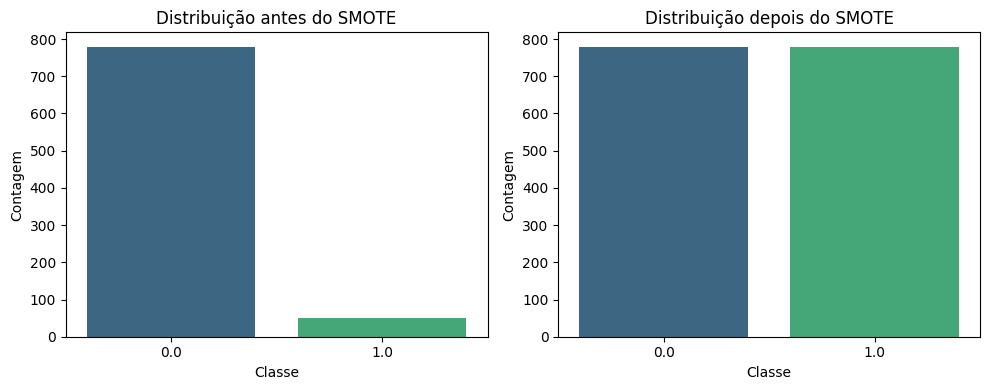

Fold 1 concluido
Fold 2 concluido
Fold 3 concluido
Fold 4 concluido
Fold 5 concluido


In [8]:
df_importances = arvore(df3, "Complicaciones cardiovasculares")

In [9]:
#==============
#Importancias
#==============
def importancias(df_importances):
    
    df_importances["Mean Importance"] = pd.to_numeric(df_importances["Mean Importance"], errors="coerce")

    df_importances = (
        df_importances
        .sort_values(by="Mean Importance", ascending=False, na_position="last")
        .reset_index(drop=True)
    )

    df_importances["Rank"] = np.arange(1, len(df_importances) + 1)

    print(df_importances.to_string(index=False))

    plt.figure(figsize=(10,5))
    plt.scatter(df_importances["Rank"], df_importances["Std Importance"], color="blue", alpha=0.7)
    plt.xlabel("Rank da Feature (1 = mais importante)")
    plt.ylabel("Desvio-padrão da importância")
    plt.title("Desvio-padrão da importância vs. Ranking")
    plt.show()

    #CART
    X_rank = df_importances["Rank"].values.reshape(-1,1)
    y_std = df_importances["Std Importance"].values

    cart = DecisionTreeRegressor(max_depth=4)
    cart.fit(X_rank, y_std)
    y_smooth = cart.predict(X_rank)

    threshold_noise = y_smooth.min()
    print("Valor mínimo:", threshold_noise)

    plt.figure(figsize=(10,5))
    plt.scatter(df_importances["Rank"], df_importances["Std Importance"], color="blue", alpha=0.5, label="Original")
    plt.plot(df_importances["Rank"], y_smooth, color="red", linewidth=2, label="CART suavizado")
    plt.xlabel("Rank da Feature (1 = mais importante)")
    plt.ylabel("Desvio-padrão da importância")
    plt.title("Suavização da curva de desvios")
    plt.axhline(y=threshold_noise, color="green", linestyle="--", label="Piso (ruído)")
    plt.legend()
    plt.show()


    noise_features = df_importances[df_importances["Mean Importance"] < threshold_noise]["Feature"].tolist()
    signal_features = df_importances[df_importances["Mean Importance"] >= threshold_noise]["Feature"].tolist()

    print("Features ruído:", noise_features)
    print("Features:", signal_features)

    return signal_features

                        Feature  Mean Importance  Std Importance  Rank
                      Diabetes          0.000805        0.001692     1
             Fibrilación atrial         0.000257        0.000879     2
                   regimensalud         0.000225        0.000451     3
                 arearesidencia         0.000225        0.001203     4
                      educacion         0.000097        0.001303     5
                 tipodepaciente         0.000000        0.000000     6
                Consumo alcohol         0.000000        0.000000     7
                            IPA         0.000000        0.000000     8
  número de cigarrillos diarios         0.000000        0.000000     9
                         FC_cat         0.000000        0.000000    10
                        potasio         0.000000        0.000000    11
        Demencia (Dxco Médico)          0.000000        0.000000    12
                Años de fumador         0.000000        0.000000    13
      

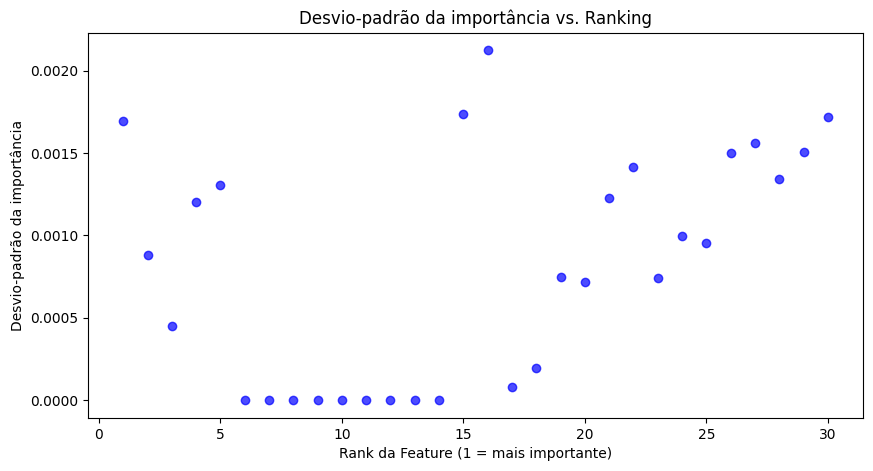

Valor mínimo: 0.0


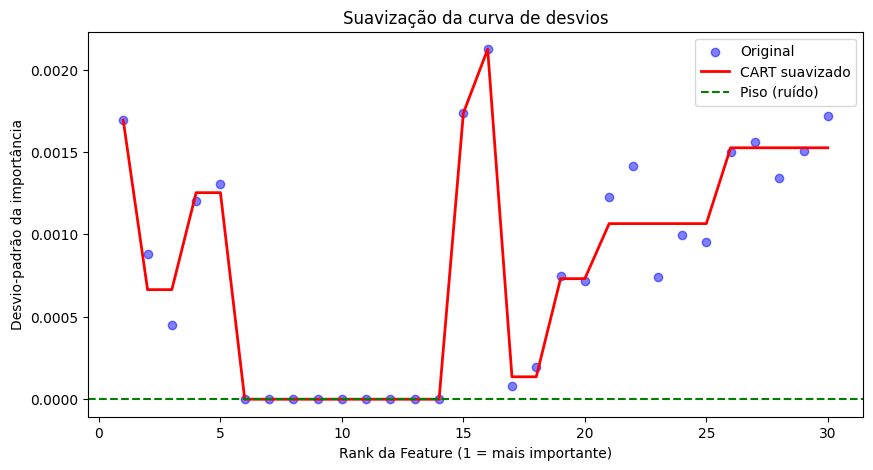

Features ruído: ['BUN_cat', 'Peso', 'EPOC', 'Enfermedad arterial periférica\xa0', 'PAS', 'edad_cat', 'NYHA', 'creatinina_cat', 'AHA', 'sexo', 'fevi_cat', 'Talla', 'IMCat', 'Comorbilidad rxcv', 'estadocivil', 'Hipertensión arterial\xa0']
Features: ['Diabetes\xa0', 'Fibrilación atrial', 'regimensalud', 'arearesidencia', 'educacion', 'tipodepaciente', 'Consumo alcohol', 'IPA', 'número de cigarrillos diarios', 'FC_cat', 'potasio', 'Demencia (Dxco Médico)\xa0', 'Años de fumador', 'Fuma actualmente']


In [10]:
signal_features = importancias(df_importances)

In [11]:
X_candidates = df[signal_features].values
print(X_candidates)

[[0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]]


In [12]:
n_repeats = 5        
n_estimators = 500    
random_state = 42

n_vars = X_candidates.shape[1]
target_col = "Complicaciones cardiovasculares"
y = df[target_col].values

errors = np.zeros((n_repeats, n_vars))

for r in range(n_repeats):
    for k in range(1, n_vars+1):
        rf = RandomForestClassifier(
            n_estimators=n_estimators,
            oob_score=True,
            bootstrap=True,
            n_jobs=-1,
            random_state=random_state + r
        )
        rf.fit(X_candidates[:, :k], y)
        errors[r, k-1] = 1 - rf.oob_score_

mean_errors = errors.mean(axis=0)
std_errors = errors.std(axis=0)

min_error = mean_errors.min()
min_index = mean_errors.argmin()

threshold = min_error + std_errors[min_index]
k_interp = np.where(mean_errors <= threshold)[0][0] + 1

print(f"Erro mínimo: {min_error:.3f} (em k={min_index+1})")
print(f"Conjunto para interpretação: usar as {k_interp} variáveis mais importantes")

interp_vars = list(range(k_interp))  

Erro mínimo: 0.060 (em k=1)
Conjunto para interpretação: usar as 1 variáveis mais importantes


In [13]:
k = k_interp
vars_k = signal_features[:k]
print(f"k={k}: {vars_k}")

k=1: ['Diabetes\xa0']
